## Setting up:

In [1]:
import pandas as pd
import os
import warnings
import massbalancemachine as mbm
from shapely.geometry import Point
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import geopandas as gpd
import salem
import logging
import re
import math
import numpy as np
import glob
from os.path import isfile, join, isdir
from geopy.distance import geodesic
from itertools import combinations
from tqdm import tqdm
from oggm import utils, workflow, tasks
from oggm import cfg as oggmCfg
from cmcrameri import cm
from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.prepro_GLAMOS_PMB import *
from scripts.config_ICE import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.ItalyAustriaConfig()

oggmCfg.initialize(logging_level='WARNING')
oggmCfg.PARAMS['border'] = 10
oggmCfg.PARAMS['use_multiprocessing'] = True
oggmCfg.PARAMS['continue_on_error'] = True
oggmCfg.PARAMS['rgi_dir'] = '/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/RGI'
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2025-05-28 11:14:47: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-05-28 11:14:47: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-05-28 11:14:47: oggm.cfg: Multiprocessing: using all available processors (N=32)
2025-05-28 11:14:48: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-05-28 11:14:48: oggm.cfg: Multiprocessing switched ON after user settings.
2025-05-28 11:14:48: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2025-05-28 11:14:48: oggm.cfg: WARNING: adding an unknown parameter `rgi_dir`:`/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/RGI` to PARAMS.


In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon

# For bars and lines:
color_diff_xgb = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 10)
color_1 = colors[0]
color_2 = '#c51b7d'

### Load all stake csv files into 1 df

In [3]:
all_files = glob.glob(os.path.join(path_PMB_WGMS_raw, "*.csv"))

# Initialize empty list to store dataframes
dfs = []

# Read each CSV file into a dataframe and append to list
for file in all_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)

# Print info
print(f"Combined {len(all_files)} CSV files into one dataframe with {len(combined_df)} rows")

display(combined_df.head(2))


Combined 543 CSV files into one dataframe with 3783 rows


,ba_floating_date,ba_stratigraphic,bs_floating_date,bs_stratigraphic,bw_floating_date,bw_stratigraphic,d1,d2,d3,ds,...,lat,lon,nswe_fall,rhos,rhow,snow_melt_fall,stake,swes,swew,yr
0,0.45,0.45,-1.60,-1.60,2.05,2.05,1988-09-20,1989-05-29,1989-09-22,NaN,...,64.790063,-18.595688,NaN,NaN,NaN,NaN,hsa11,NaN,NaN,1989
1,-0.80,-0.80,-2.24,-2.24,1.44,1.44,1989-09-22,1990-05-14,1990-09-16,NaN,...,64.790063,-18.595688,NaN,NaN,NaN,NaN,hsa11,NaN,NaN,1990


###### Split into annual and winter rows

In [4]:
def split_stake_measurements(df_stakes):
    """
    Split stake measurements into separate annual and winter records.
    Only includes measurements where the mass balance value is not NaN.
    
    Args:
        df_stakes: DataFrame with combined stake measurement data
        
    Returns:
        DataFrame with separate rows for annual and winter measurements
    """
    
    # Create annual measurements dataframe - only where ba is not NaN
    annual_df = df_stakes[df_stakes['ba_floating_date'].notna()].copy()
    annual_df['FROM_DATE'] = annual_df['d1']
    annual_df['TO_DATE'] = annual_df['d3']
    annual_df['POINT_BALANCE'] = annual_df['ba_floating_date']
    annual_df['PERIOD'] = 'annual'
    annual_df['YEAR'] = annual_df['yr']
    
    # Create winter measurements dataframe - only where bw is not NaN
    winter_df = df_stakes[df_stakes['bw_floating_date'].notna()].copy()
    winter_df['FROM_DATE'] = winter_df['d1']
    winter_df['TO_DATE'] = winter_df['d2']
    winter_df['POINT_BALANCE'] = winter_df['bw_floating_date']
    winter_df['PERIOD'] = 'winter'
    winter_df['YEAR'] = annual_df['yr']
    """
    # Create summer measurements dataframe - only where bs is not NaN
    summer_df = df_stakes[df_stakes['bs_floating_date'].notna()].copy()
    summer_df['FROM_DATE'] = summer_df['d2']
    summer_df['TO_DATE'] = summer_df['d3']
    summer_df['POINT_BALANCE'] = summer_df['bs_floating_date']
    summer_df['PERIOD'] = 'summer'
    summer_df['YEAR'] = annual_df['yr']
    """
    # Combine both dataframes
    combined_df = pd.concat([annual_df, winter_df], ignore_index=True) # Add ", summer_df" if needed
    
    # Select only necessary columns
    columns_to_drop = ['ba_floating_date', 'ba_stratigraphic', 'bs_floating_date', 'bs_stratigraphic', 'bw_floating_date', 'bw_stratigraphic',
                        'd1', 'd2', 'd3', 'ds', 'dw', 'fall_elevation', 'ice_melt_fall', 'ice_melt_spring', 'snow_melt_fall', 
                        'rhos', 'rhow', 'yr', 'nswe_fall', 'swes', 'swew']
    result_df = combined_df.drop(columns=columns_to_drop)
    
    return result_df

df_stakes_split = split_stake_measurements(combined_df)

# Convert date columns to string in 'YYYYMMDD' format
df_stakes_split['TO_DATE'] = pd.to_datetime(df_stakes_split['TO_DATE']).dt.strftime('%Y%m%d')
df_stakes_split['FROM_DATE'] = pd.to_datetime(df_stakes_split['FROM_DATE']).dt.strftime('%Y%m%d')

display(df_stakes_split)

display(df_stakes_split[df_stakes_split['TO_DATE'].isna()])

,elevation,lat,lon,stake,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
0,1049.6,64.790063,-18.595688,hsa11,19880920,19890922,0.45,annual,1989.0
1,1049.4,64.790063,-18.595688,hsa11,19890922,19900916,-0.80,annual,1990.0
2,1049.1,64.790063,-18.595688,hsa11,19900916,19910912,-2.37,annual,1991.0
3,1048.9,64.790063,-18.595688,hsa11,19910912,19920920,0.65,annual,1992.0
4,1048.6,64.790063,-18.595688,hsa11,19920920,19930917,-0.06,annual,1993.0
...,...,...,...,...,...,...,...,...,...
6593,1697.0,64.793858,-18.843883,hsa17,20191106,20200429,2.04,winter,2020.0
6594,1697.0,64.793858,-18.843883,hsa17,20201010,20210503,1.93,winter,2021.0
6595,1697.0,64.793858,-18.843883,hsa17,20211021,20220427,2.74,winter,2022.0
6596,1697.0,64.793858,-18.843883,hsa17,20221018,20230426,1.97,winter,2023.0


,elevation,lat,lon,stake,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
447,761.04,64.319255,-18.108742,T01,20221027,NaN,-6.6000,annual,2023.0
670,844.00,64.575920,-20.032940,L12,20070925,NaN,-3.8690,annual,2008.0
1178,839.45,64.797799,-16.832915,D01,NaN,NaN,-4.9000,annual,2023.0
1181,1197.60,64.740622,-17.051846,D10,19961001,NaN,-1.2005,annual,1997.0
1282,173.85,64.105975,-16.375490,Br2,20201010,NaN,-9.9300,annual,2021.0
1659,1522.00,64.378917,-16.081383,BB0,19980926,NaN,1.8580,annual,1999.0
2722,364.04,64.140565,-16.400018,Br3,20201010,NaN,-7.3500,annual,2021.0
2781,743.00,64.530701,-20.432091,L02,20131119,NaN,-4.9710,annual,2014.0


###### Fix NaN dates by adding hydrological year dates. (It would be nicer if this code also checked if there was a previous year of the same stake with a date and then takes that date instead of hydr. year)

In [5]:
display(df_stakes_split[df_stakes_split['FROM_DATE'].isna()])
display(df_stakes_split[df_stakes_split['TO_DATE'].isna()])
display(df_stakes_split[df_stakes_split['YEAR'].isna()])

# Change NaN year values to the year of the TO_DATE
df_stakes_split.loc[df_stakes_split['YEAR'].isna(), 'YEAR'] = df_stakes_split.loc[df_stakes_split['YEAR'].isna(), 'TO_DATE'].astype(str).str[:4].astype(float)

# Set FROM_DATE from NaN to 01 Oct of previous year
df_stakes_split.loc[df_stakes_split['FROM_DATE'].isna(), 'FROM_DATE'] = (
    (df_stakes_split.loc[df_stakes_split['FROM_DATE'].isna(), 'YEAR'].astype(int) - 1).astype(str) + '1001'
)
# Set TO_DATE from NaN to 01 Oct of the year (as only annual rows have NaN)
df_stakes_split.loc[df_stakes_split['TO_DATE'].isna(), 'TO_DATE'] = (
    df_stakes_split.loc[df_stakes_split['TO_DATE'].isna(), 'YEAR'].astype(int).astype(str) + '1001'
)


,elevation,lat,lon,stake,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
35,1418.800000,64.424999,-17.353384,Gh17a,NaN,20071010,1.593157,annual,2007.0
36,684.000000,64.215250,-16.316333,Br5,NaN,20001019,-2.791500,annual,2000.0
38,1088.800000,64.743091,-16.830083,D04,NaN,19930928,-0.170000,annual,1993.0
39,1208.680000,63.615526,-19.065774,Mst0,NaN,20010829,4.833000,annual,2001.0
40,1032.400000,64.330727,-18.044974,Tu04,NaN,19920929,-1.370000,annual,1992.0
...,...,...,...,...,...,...,...,...,...
6480,1590.000000,64.530167,-17.009000,D09,NaN,19960507,1.680000,winter,1996.0
6484,1572.910000,64.530269,-17.009506,D09,NaN,20050509,1.662000,winter,2005.0
6503,890.643779,64.550109,-20.417109,L03,NaN,19970428,1.900000,winter,1997.0
6530,1892.000000,64.656667,-17.433333,Bafk04,NaN,20150610,2.390000,winter,NaN


,elevation,lat,lon,stake,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
447,761.04,64.319255,-18.108742,T01,20221027,NaN,-6.6000,annual,2023.0
670,844.00,64.575920,-20.032940,L12,20070925,NaN,-3.8690,annual,2008.0
1178,839.45,64.797799,-16.832915,D01,NaN,NaN,-4.9000,annual,2023.0
1181,1197.60,64.740622,-17.051846,D10,19961001,NaN,-1.2005,annual,1997.0
1282,173.85,64.105975,-16.375490,Br2,20201010,NaN,-9.9300,annual,2021.0
1659,1522.00,64.378917,-16.081383,BB0,19980926,NaN,1.8580,annual,1999.0
2722,364.04,64.140565,-16.400018,Br3,20201010,NaN,-7.3500,annual,2021.0
2781,743.00,64.530701,-20.432091,L02,20131119,NaN,-4.9710,annual,2014.0


,elevation,lat,lon,stake,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
3217,1047.900000,64.790063,-18.595688,hsa11,19950915,19960512,1.0200,winter,NaN
3247,1807.932370,63.985000,-16.661810,Or06-18,NaN,20180604,5.3268,winter,NaN
3248,700.000000,64.218083,-16.315933,Br5,19971001,19980321,0.7300,winter,NaN
3249,690.000000,64.217533,-16.315083,Br5,NaN,19990526,0.4360,winter,NaN
3252,687.500000,64.216761,-16.315756,Br5,20011027,20020506,0.7870,winter,NaN
...,...,...,...,...,...,...,...,...,...
6331,698.580000,64.116938,-17.832906,S01,20221018,20230506,0.1430,winter,NaN
6332,1343.793572,64.633000,-20.433500,L09,NaN,19970422,1.8660,winter,NaN
6418,1040.000000,64.516000,-15.617750,Hof01a,NaN,20010430,2.4200,winter,NaN
6479,1589.300000,64.530834,-17.007278,D09,19940916,19950501,2.1700,winter,NaN


#### Check for problematic date ranges

In [6]:
def check_period_consistency(df):
    """
    Checks if date ranges make sense for annual and winter periods:
    Returns dataframes with inconsistent periods
    """

    df_check = df.copy()
    
    # Convert dates to datetime objects
    df_check['FROM_DATE_DT'] = pd.to_datetime(df_check['FROM_DATE'], format='%Y%m%d')
    df_check['TO_DATE_DT'] = pd.to_datetime(df_check['TO_DATE'], format='%Y%m%d')
    
    # Calculate month difference
    df_check['MONTH_DIFF'] = ((df_check['TO_DATE_DT'].dt.year - df_check['FROM_DATE_DT'].dt.year) * 12 + 
                             df_check['TO_DATE_DT'].dt.month - df_check['FROM_DATE_DT'].dt.month)
    
    # Identify inconsistent periods
    ## 9-15 and 4-9 excludes the normal varying range
    annual_inconsistent = df_check[(df_check['PERIOD'] == 'annual') & 
                                 ((df_check['MONTH_DIFF'] < 9) | (df_check['MONTH_DIFF'] > 15))]
    
    winter_inconsistent = df_check[(df_check['PERIOD'] == 'winter') & 
                                 ((df_check['MONTH_DIFF'] < 4) | (df_check['MONTH_DIFF'] > 9))]
    
    total_annual = len(df_check[df_check['PERIOD'] == 'annual'])
    total_winter = len(df_check[df_check['PERIOD'] == 'winter'])
    
    print(f"Annual periods: {len(annual_inconsistent)} out of {total_annual} ({len(annual_inconsistent)/total_annual*100:.1f}%) are inconsistent")
    print(f"Winter periods: {len(winter_inconsistent)} out of {total_winter} ({len(winter_inconsistent)/total_winter*100:.1f}%) are inconsistent")
    
    return annual_inconsistent, winter_inconsistent

annual_inconsistent, winter_inconsistent = check_period_consistency(df_stakes_split)


# Display the inconsistent records
if len(annual_inconsistent) > 0:
    print("\nInconsistent annual periods:")
    display(annual_inconsistent)

if len(winter_inconsistent) > 0:
    print("\nInconsistent winter periods:")
    display(winter_inconsistent)

# Only index 5084 is unreasonabl (-2), probably wrong FROM_DATE year, change to year - 1
df_stakes_split.loc[5084, 'FROM_DATE'] = '19960825'


Annual periods: 0 out of 3210 (0.0%) are inconsistent
Winter periods: 13 out of 3388 (0.4%) are inconsistent

Inconsistent winter periods:


,elevation,lat,lon,stake,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,FROM_DATE_DT,TO_DATE_DT,MONTH_DIFF
4108,1970.0,64.639364,-17.523302,K06,19970825,19980615,1.9165,winter,1998.0,1997-08-25,1998-06-15,10
4109,1970.0,64.639217,-17.523233,K06,19980826,19990610,2.1760,winter,1999.0,1998-08-26,1999-06-10,10
4158,1770.0,64.566674,-17.466664,GL10,19961001,19970825,1.2000,winter,1997.0,1996-10-01,1997-08-25,10
4875,1411.0,64.416605,-17.336742,Bor,19960830,19970611,2.0000,winter,1997.0,1996-08-30,1997-06-11,10
4876,1380.0,64.415715,-17.336125,Bor,19970826,19980607,1.5915,winter,1998.0,1997-08-26,1998-06-07,10
4877,1385.0,64.415667,-17.336017,Bor,19980825,19990606,2.6920,winter,1999.0,1998-08-25,1999-06-06,10
4961,1740.0,64.533335,-17.466671,GL9a,19961001,19970825,0.9300,winter,1997.0,1996-10-01,1997-08-25,10
4997,1825.0,63.996503,-16.650666,Oer01,19931001,19940829,7.7800,winter,1994.0,1993-10-01,1994-08-29,10
4998,1825.0,63.996503,-16.650666,Oer01,19940829,19950611,5.7500,winter,1995.0,1994-08-29,1995-06-11,10
5084,1635.0,64.583004,-17.265992,GL10a,19970825,19970610,1.4985,winter,1997.0,1997-08-25,1997-06-10,-2


###### Rename Columns, we can skip the close stake removal, as seen form the leaflet map online, the stakes are spaced out.

In [7]:
df_stakes_renamed = df_stakes_split.rename(columns={
    'lat': 'POINT_LAT', 
    'lon': 'POINT_LON',
    'elevation': 'POINT_ELEVATION',
    'stake': 'ID',
})

##### Find RGIId

In [8]:
## This downloads shapefiles for all RGI regions for some reason
#utils.get_rgi_region_file(region="06", version="6")

# Load glacier outlines
glacier_outline = gpd.read_file('/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/RGI/06_rgi60_Iceland/06_rgi60_Iceland.shp')

# Add RGI IDs through intersection
df_stakes_renamed_rgiid = mbm.data_processing.utils.get_rgi(data=df_stakes_renamed,
                                           glacier_outlines=glacier_outline)

display(df_stakes_renamed_rgiid[df_stakes_renamed_rgiid['RGIId'].isna()])
# Remove (nine) stakes without RGIId, as they wont have OGGM data anyways
df_stakes_renamed_rgiid = df_stakes_renamed_rgiid.dropna(subset=['RGIId'])

,POINT_ELEVATION,POINT_LAT,POINT_LON,ID,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId
1007,490.0,64.492780,-20.43633,L01,19971012,19980916,-7.0300,annual,1998.0,NaN
1008,505.0,64.493820,-20.43648,L01,19980916,19990928,-4.9500,annual,1999.0,NaN
1009,490.0,64.493430,-20.43622,L01,19990928,20001004,-5.4825,annual,2000.0,NaN
1010,485.0,64.493820,-20.43647,L01,20001004,20011005,-6.3615,annual,2001.0,NaN
3774,715.0,64.776661,-16.05650,B08,19940915,19950503,0.5400,winter,1995.0,NaN
4274,490.0,64.492780,-20.43633,L01,19971012,19980417,0.2900,winter,1998.0,NaN
4275,505.0,64.493820,-20.43648,L01,19980916,19990422,1.6690,winter,1999.0,NaN
4276,490.0,64.493430,-20.43622,L01,19990928,20000427,1.3200,winter,2000.0,NaN
4277,485.0,64.493820,-20.43647,L01,20001004,20010419,0.8845,winter,2001.0,NaN


#### Add OGGM data

In [9]:
# initialize OGGM glacier directories
gdirs, rgidf = initialize_oggm_glacier_directories(
    working_dir= path_OGGM,
    rgi_region="06", #06 iceland
    rgi_version="6",
    base_url=
    "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/",
    log_level='WARNING',
    task_list=None,
)


unique_rgis = df_stakes_renamed_rgiid['RGIId'].unique()

run = False
if run:
    export_oggm_grids(gdirs, subset_rgis=unique_rgis, output_path=path_OGGM_xrgrids)

## Around 10% of all the measurements have no hugonnet_dhdt data, so I removed the entire variable from merge_pmb_with_oggm_data()
df_stakes_topo = merge_pmb_with_oggm_data(df_pmb=df_stakes_renamed_rgiid,
                                       gdirs=gdirs,
                                       rgi_region="06", #06 iceland
                                       rgi_version="6")
                                       


2025-05-28 11:15:08: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-05-28 11:15:08: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-05-28 11:15:08: oggm.cfg: Multiprocessing: using all available processors (N=32)


2025-05-28 11:15:08: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-05-28 11:15:08: oggm.cfg: Multiprocessing switched ON after user settings.
2025-05-28 11:15:08: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2025-05-28 11:15:08: oggm.workflow: init_glacier_directories from prepro level 3 on 568 glaciers.
2025-05-28 11:15:08: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 568 glaciers
2025-05-28 11:15:11: oggm.workflow: Execute entity tasks [gridded_attributes] on 568 glaciers


###### Get Glacier names from RGIId

In [10]:
# Create a dictionary mapping from RGIId to glacier name
rgi_to_name_dict = dict(zip(rgidf.RGIId, rgidf.Name))
df_stakes_topo['GLACIER'] = df_stakes_topo['RGIId'].map(rgi_to_name_dict)


display(df_stakes_topo[df_stakes_topo['GLACIER'].isna()])


,POINT_ELEVATION,POINT_LAT,POINT_LON,ID,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,consensus_ice_thickness,millan_v,within_glacier_shape,GLACIER
39,1208.680000,63.615526,-19.065774,Mst0,20001001,20010829,4.8330,annual,2001.0,RGI60-06.00328,95.806865,2.027245,1206.320801,421.029633,124.362785,True,None
92,1175.330444,64.700000,-20.050000,L15,19961001,19971012,0.2825,annual,1997.0,RGI60-06.00303,316.579186,1.546897,1153.062378,163.393127,9.938813,True,None
262,1111.700000,64.527256,-15.589690,Hof01b,20011001,20020914,0.1080,annual,2002.0,RGI60-06.00466,137.620553,1.022620,1095.403198,330.246216,32.073280,True,None
266,1074.300000,64.640086,-15.411253,E07,20191001,20201013,-0.8115,annual,2020.0,RGI60-06.00411,35.723471,2.168154,1076.037231,236.136032,37.086124,True,None
267,1072.950000,64.640139,-15.411243,E07,20201013,20211015,-2.1020,annual,2021.0,RGI60-06.00411,35.723471,2.168154,1076.037231,236.136032,37.086124,True,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6414,1143.420000,64.538935,-15.597265,Hof01,20191019,20200429,1.6210,winter,2020.0,RGI60-06.00466,172.553104,1.078475,1138.249268,353.202454,44.098957,True,None
6415,1142.660000,64.538977,-15.597228,Hof01,20201008,20210502,1.8735,winter,2021.0,RGI60-06.00466,172.553104,1.078475,1138.249268,353.202454,44.098957,True,None
6416,1143.060000,64.539036,-15.596943,Hof01,20211015,20220504,2.7400,winter,2022.0,RGI60-06.00466,172.553104,1.078475,1138.249268,353.202454,44.098957,True,None
6417,1142.890000,64.539155,-15.597171,Hof01,20221017,20230503,1.9350,winter,2023.0,RGI60-06.00466,172.553104,1.078475,1138.249268,353.202454,44.098957,True,None


###### Multiple RGIIds have no associated glacier name, assign the 'RGIId' as the 'GLACIER' name

In [11]:
missing_rgi_ids = df_stakes_topo.loc[df_stakes_topo['GLACIER'].isna(), 'RGIId'].unique()
print(f"Number of unique RGI IDs without names: {len(missing_rgi_ids)}")
print("RGI IDs without names:", missing_rgi_ids)

# Just assign RGIId to 'GLACIER' as name for the ones that are missing
df_stakes_topo.loc[df_stakes_topo['GLACIER'].isna(), 'GLACIER'] = df_stakes_topo.loc[df_stakes_topo['GLACIER'].isna(), 'RGIId']

Number of unique RGI IDs without names: 32
RGI IDs without names: ['RGI60-06.00328' 'RGI60-06.00303' 'RGI60-06.00466' 'RGI60-06.00411'
 'RGI60-06.00302' 'RGI60-06.00359' 'RGI60-06.00340' 'RGI60-06.00238'
 'RGI60-06.00320' 'RGI60-06.00342' 'RGI60-06.00480' 'RGI60-06.00465'
 'RGI60-06.00294' 'RGI60-06.00292' 'RGI60-06.00232' 'RGI60-06.00478'
 'RGI60-06.00301' 'RGI60-06.00413' 'RGI60-06.00311' 'RGI60-06.00350'
 'RGI60-06.00476' 'RGI60-06.00228' 'RGI60-06.00409' 'RGI60-06.00349'
 'RGI60-06.00422' 'RGI60-06.00305' 'RGI60-06.00425' 'RGI60-06.00306'
 'RGI60-06.00479' 'RGI60-06.00296' 'RGI60-06.00445' 'RGI60-06.00474']


RGI60-06.00377


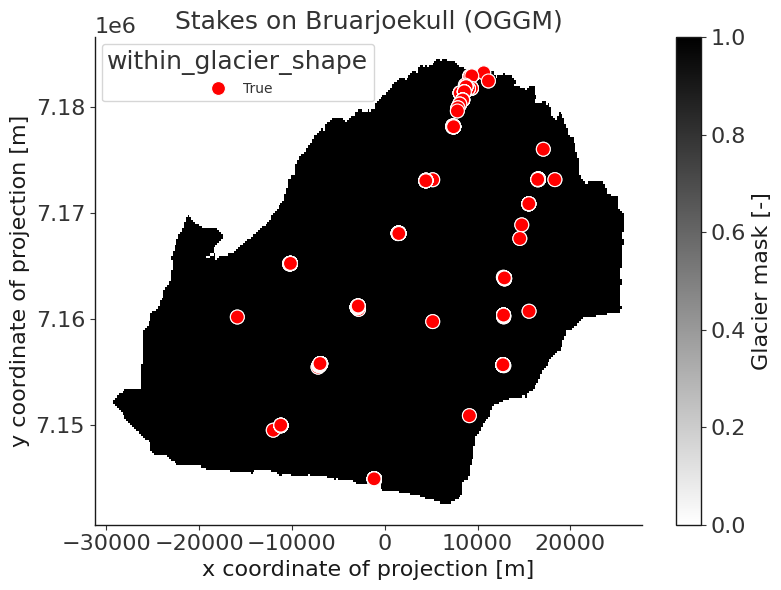

In [12]:
# Example:
glacierName = 'Bruarjoekull'
# stakes
df_stakes_topo_1 = df_stakes_topo.copy()
df_stakes_topo_1 = df_stakes_topo_1[(df_stakes_topo_1['GLACIER'] == glacierName)]
RGIId = df_stakes_topo_1['RGIId'].unique()[0]
print(RGIId)
# open OGGM xr for glacier
# Get oggm data for that RGI grid
ds_oggm = xr.open_dataset(f'/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/OGGM/xr_grids/{RGIId}.zarr')

# Define the coordinate transformation
transf = pyproj.Transformer.from_proj(
    pyproj.CRS.from_user_input("EPSG:4326"),  # Input CRS (WGS84)
    pyproj.CRS.from_user_input(ds_oggm.pyproj_srs),  # Output CRS from dataset
    always_xy=True)

# Transform all coordinates in the group
lon, lat = df_stakes_topo_1["POINT_LON"].values, df_stakes_topo_1["POINT_LAT"].values
x_stake, y_stake = transf.transform(lon, lat)
df_stakes_topo_1['x'] = x_stake
df_stakes_topo_1['y'] = y_stake

# plot stakes
plt.figure(figsize=(8, 6))
ds_oggm.glacier_mask.plot(cmap='binary')
sns.scatterplot(df_stakes_topo_1,
                x='x',
                y='y',
                hue='within_glacier_shape',
                palette=['r', 'b'])
plt.title(f'Stakes on {glacierName} (OGGM)')
plt.tight_layout()

In [ ]:
# Restrict to within glacier shape
df_stakes_topo = df_stakes_topo[df_stakes_topo['within_glacier_shape'] == True]
df_stakes_topo = df_stakes_topo.drop(columns=['within_glacier_shape'])

# Display rows that have any NaN values
display(df_stakes_topo[df_stakes_topo.isna().any(axis=1)])

# Fill NaN values in POINT_ELEVATION with values from topo for 30 rows
df_stakes_topo.loc[df_stakes_topo['POINT_ELEVATION'].isna(), 'POINT_ELEVATION'] = df_stakes_topo.loc[df_stakes_topo['POINT_ELEVATION'].isna(), 'topo']

# Drop 4 rows where consensus_ice_thickness is NaN
df_stakes_topo_dropped = df_stakes_topo.dropna(subset=['consensus_ice_thickness'])

display(len(df_stakes_topo_dropped[df_stakes_topo_dropped['consensus_ice_thickness'].isna()]))
display(len(df_stakes_topo_dropped[df_stakes_topo_dropped['POINT_ELEVATION'].isna()]))


,POINT_ELEVATION,POINT_LAT,POINT_LON,ID,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,consensus_ice_thickness,millan_v,GLACIER
34,NaN,64.790063,-18.595688,hsa11,20231024,20241104,-1.770,annual,2024.0,RGI60-06.00234,158.071560,2.508572,1034.505493,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E)
210,NaN,64.770162,-18.543084,hsa9,20231024,20241104,-3.230,annual,2024.0,RGI60-06.00234,128.989461,5.198116,851.219482,288.274323,2.300197,Thjorsarjoekull (Hofsjoekull E)
513,NaN,64.749711,-19.000955,hsv15,20231024,20241106,1.370,annual,2024.0,RGI60-06.00236,245.700865,4.345945,1467.363892,292.617218,23.039806,Blagnipujoekull (Hofsjoekull SW)
587,NaN,64.957680,-18.860046,hn11,20231025,20241104,-2.600,annual,2024.0,RGI60-06.00238,347.548357,3.425522,1043.424805,205.175507,5.888263,RGI60-06.00238
622,NaN,64.838974,-18.708493,hsa15,20231024,20241104,1.230,annual,2024.0,RGI60-06.00234,105.413199,2.308865,1450.369507,448.350372,48.769199,Thjorsarjoekull (Hofsjoekull E)
850,NaN,64.934272,-18.846087,hn12,20231025,20241104,-1.060,annual,2024.0,RGI60-06.00238,323.152970,3.079840,1158.750488,252.628937,9.670280,RGI60-06.00238
1011,486.0,64.494360,-20.435610,L01,20011005,20021031,-7.371,annual,2002.0,RGI60-06.00291,224.979505,1.592727,479.944916,NaN,0.000000,Hagafellsjoekull West
1117,NaN,64.809036,-18.869327,h18,20231025,20241106,2.790,annual,2024.0,RGI60-06.00236,302.746769,1.193531,1783.155029,549.476196,5.221010,Blagnipujoekull (Hofsjoekull SW)
1225,NaN,64.813665,-18.647927,hsa13,20231024,20241104,0.270,annual,2024.0,RGI60-06.00234,113.855244,4.441315,1227.970093,280.746979,72.343048,Thjorsarjoekull (Hofsjoekull E)
1261,NaN,64.869136,-18.867241,hn15,20231025,20241106,1.710,annual,2024.0,RGI60-06.00238,356.037899,4.534064,1423.256226,186.849655,35.753441,RGI60-06.00238


0

0

In [15]:
display(df_stakes_topo_dropped.head(2))
# Create new POINT_ID column
df_stakes_topo_dropped['POINT_ID'] = (
    df_stakes_topo_dropped['GLACIER'] + '_' + 
    df_stakes_topo_dropped['YEAR'].astype(str) + '_' + 
    df_stakes_topo_dropped['PERIOD'].astype(str) + '_' +
    df_stakes_topo_dropped['ID'].astype(str)
)

df_stakes_topo_dropped = df_stakes_topo_dropped.drop(columns=['ID'])

display(df_stakes_topo_dropped.head(2))

,POINT_ELEVATION,POINT_LAT,POINT_LON,ID,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,consensus_ice_thickness,millan_v,GLACIER
0,1049.6,64.790063,-18.595688,hsa11,19880920,19890922,0.45,annual,1989.0,RGI60-06.00234,158.07156,2.508572,1034.505493,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E)
1,1049.4,64.790063,-18.595688,hsa11,19890922,19900916,-0.80,annual,1990.0,RGI60-06.00234,158.07156,2.508572,1034.505493,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E)


,POINT_ELEVATION,POINT_LAT,POINT_LON,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,consensus_ice_thickness,millan_v,GLACIER,POINT_ID
0,1049.6,64.790063,-18.595688,19880920,19890922,0.45,annual,1989.0,RGI60-06.00234,158.07156,2.508572,1034.505493,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...
1,1049.4,64.790063,-18.595688,19890922,19900916,-0.80,annual,1990.0,RGI60-06.00234,158.07156,2.508572,1034.505493,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1990.0_annual_...


In [ ]:
output_path = (path_PMB_WGMS_csv + 'ICE_dataset_all_oggm.csv')
df_stakes_topo_dropped.to_csv(output_path, index=False)